In [5]:
%matplotlib inline

In [6]:
#!pip install -r requirements.txt

In [7]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv as catboost_cv
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, LeaveOneOut, LeavePOut)
# --- Import scikit-learn metrics directly ---
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

from scipy.stats import randint, uniform
import optuna # Added import
from imblearn.over_sampling import RandomOverSampler # Added import

# Import necessary functions from utils.py (excluding metrics)
from utils import (
    plot_pred_vs_actual_plotly,
    plot_shap_summary,
    plot_shap_waterfall,
    plot_shap_dependence,
    plot_native_feature_importance # Keep native importance plot
    # Removed RMSE, MAPE, calculate_r2 from utils import
)

In [8]:
DATA_PATH = "data/conso_data.csv"
TARGET_COLUMN = "pitd"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Features for special handling
FEATURES_TO_QUANTIZE = ['pitd1'] # Features for custom quantization
CUSTOM_BORDER_COUNT = 1024         # Border count for specific quantization
MONOTONE_CONSTRAINTS_CONFIG = {'teff_cwv': -1} # Monotonic constraints {'feature_name': direction}

# Tuning settings
N_ITER_RANDOM_SEARCH = 50 # Iterations for RandomizedSearchCV
N_TRIALS_OPTUNA = 100      # Trials for Optuna optimization
CV_FOLDS_TUNING = 5       # Folds for CV during tuning

# File to save/load best parameters
PARAMS_FILENAME = 'best_catboost_params.json'

# Oversampling settings
HOLIDAY_COLUMN = 'is_holiday' # *** IMPORTANT: ASSUMING this column exists or will be created ***
ENABLE_OVERSAMPLING = False

GRID_SEARCH_POINTS = 3 # Number of points per continuous parameter in Grid Search (e.g., 3 = low, center, high)
GRID_SEARCH_RANGE_FACTOR = 0.15 

In [9]:
df = pd.read_csv("data/conso_data.csv")

In [10]:
# Calculate Heating Degree Days (HDD)
base_temp = 16.5
# Ensure 'tmoy' is numeric before calculation
df['tmoy'] = pd.to_numeric(df['tmoy'], errors='coerce')
df['hdd'] = (base_temp - df['tmoy']).clip(lower=0)

In [11]:
# Convert object to category
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [12]:
X = df.drop(columns=["pitd","target"]) #target
y = df['pitd']

In [13]:
num_variables = X.columns[X.dtypes == 'float64'].tolist()
cat_variables = X.columns[X.dtypes == 'category'].tolist()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
features_to_quantize_names = ['pitd1'] 
custom_border_count = 1024 

quantization_settings = []
if features_to_quantize_names:
    print(f"Configuration de la quantification personnalisée (border_count={custom_border_count}) pour: {features_to_quantize_names}")
    valid_feature_indices = {}
    for feature_name in features_to_quantize_names:
        valid_feature_indices[feature_name] = X_train.columns.get_loc(feature_name)
    quantization_settings = [f'{idx}:border_count={custom_border_count}' for name, idx in valid_feature_indices.items()]
    
float_features = X_train.select_dtypes(include=np.float64).columns.tolist()
float_feature_indices = {name: i for i, name in enumerate(X_train.columns) if name in float_features}

Configuration de la quantification personnalisée (border_count=1024) pour: ['pitd1']


In [20]:
params_filename = 'best_random_search_params.json'

In [31]:
if not os.path.exists(params_filename):

    cb_estimator = CatBoostRegressor(cat_features=cat_variables, verbose = 0, monotone_constraints = {'teff_cwv': -1}, per_float_feature_quantization= quantization_settings)
    param_dist = {
        'iterations': randint(500, 2000),
        'learning_rate': uniform(0.01, 0.2),
        'depth': randint(4, 10),
        'l2_leaf_reg': uniform(1, 10),
        'border_count': randint(32, 256),

        #'monotone_constraints': [
        #    {'teff_cwv': -1},
        #    {'hdd': 1},
        #    {'teff_cwv': -1, 'hdd': 1}
        #],
    #
        #'per_float_feature_quantization': [ 
        #    [f'{float_feature_indices["pitd1"]}:{CUSTOM_BORDER_COUNT}'] if "pitd1" in float_feature_indices else None,
        #    ([f'{float_feature_indices["pitd1"]}:512', f'{float_feature_indices["hdd"]}:64']
        #     if "pitd1" in float_feature_indices and "hdd" in float_feature_indices else None)
        #]
    }


    random_search = RandomizedSearchCV(
        estimator=cb_estimator,
        param_distributions=param_dist,
        n_iter=N_ITER_RANDOM_SEARCH,
        cv=CV_FOLDS_TUNING,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )

    fit_params = {
        'early_stopping_rounds': 50 
    }

    best_params_random = {}
    best_score_rs = -np.inf
    final_model_rs = None
    rs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        random_search.fit(X_train, y_train, **fit_params)
        if hasattr(random_search, 'best_params_'):
            best_params_random = random_search.best_params_
            best_score_rs = random_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_rs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_rs:.4f}")
            print(json.dumps(best_params_random, indent=4))

            with open(params_filename, 'w') as f:
                json.dump(best_params_random, f, indent=4) 
        else:
            print("Randomized Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Randomized Search fit: {e}")

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

Best Internal CV Score (Negative RMSE): -16905.7915
Equivalent Best RMSE: 16905.7915
{
    "border_count": 191,
    "depth": 4,
    "iterations": 1636,
    "l2_leaf_reg": 1.6489224710898156,
    "learning_rate": 0.06078308278686894
}


In [23]:
with open(params_filename, 'r') as f:
    best_params_random = json.load(f)

In [25]:
final_model_rs = CatBoostRegressor(cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_random)
final_model_rs.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0, plot=True) 
print("\n--- Randomized Search Final Model Evaluation ---")
final_model_rs.save_model(
    "models/RS_model_no_target.cbm"    
)
y_pred_rs = final_model_rs.predict(X_test)
rmse_rs = root_mean_squared_error(y_test, y_pred_rs)
mape_rs = mean_absolute_percentage_error(y_test, y_pred_rs) * 100
r2_rs = r2_score(y_test, y_pred_rs)
print(f"Test RMSE: {rmse_rs:.2f}, MAPE: {mape_rs:.2f}%, R2: {r2_rs:.4f}")
rs_model_metrics = {'RMSE': rmse_rs, 'MAPE': mape_rs, 'R2': r2_rs}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Randomized Search Final Model Evaluation ---
Test RMSE: 17022.37, MAPE: 4.30%, R2: 0.9943


In [34]:
params_filename = 'best_params_gs.json' 
if not os.path.exists(params_filename):
    # comparer optuna et grid search 
    fit_params = {
            'early_stopping_rounds': 50 
        }
    center_iterations = best_params_random.get('iterations', 1000)
    center_lr = best_params_random.get('learning_rate', 0.05)
    center_depth = best_params_random.get('depth', 6)
    center_l2 = best_params_random.get('l2_leaf_reg', 3)
    center_border = best_params_random.get('border_count', 128)
    best_rs_constraints = best_params_random.get('monotone_constraints', None)
    best_rs_quantization = best_params_random.get('per_float_feature_quantization', None)
    # --- Create the new, tighter, and more populated grid ---

    param_grid_gs = {

        'iterations': [
            int(max(100, center_iterations * 0.95)), # ~ -10%
            center_iterations,                      # center
            int(center_iterations * 1.05),           # ~ +10%
        ],


        'learning_rate': np.linspace(center_lr * 0.9, center_lr * 1.1, 3).tolist(),

        'depth': list(range(max(2, center_depth - 1), center_depth + 2)),

        'l2_leaf_reg': np.linspace(center_l2 * 0.9, center_l2 * 1.1, 3).tolist(),

        'border_count': list(np.unique( # Use unique to avoid duplicates if steps are small
            [
                int(max(32, center_border * 0.90)), # ~ -25%
                center_border,
                int(min(255, center_border * 1.1 ))  # ~ +25% (adjust max 255 if needed)
            ]
        ).astype(int))
    }


    cb_estimator_gs = CatBoostRegressor(
        cat_features=cat_variables,
        loss_function='RMSE', eval_metric='RMSE',
        monotone_constraints={'teff_cwv': -1},             
        per_float_feature_quantization=quantization_settings, 
        verbose=0,
    )


    grid_search = GridSearchCV(
        estimator=cb_estimator_gs, param_grid=param_grid_gs, cv=CV_FOLDS_TUNING,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1 )


    best_params_gs = {}
    best_score_gs = -np.inf
    final_model_gs = None
    gs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        grid_search.fit(X_train, y_train, **fit_params)
        if hasattr(grid_search, 'best_params_'):
            best_params_gs = grid_search.best_params_
            best_score_gs = grid_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_gs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_gs:.4f}")
            print("Best Parameters Found by Grid Search:")
            best_params_gs['border_count'] = int(best_params_gs['border_count'])
            print(json.dumps(best_params_gs, indent=4))
            params_filename = 'best_gs_params.json' 
            with open('best_params_gs.json', "w") as f:
                json.dump(best_params_gs, f, indent=4)
        else:
            print("Grid Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Grid Search fit: {e}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

Best Internal CV Score (Negative RMSE): -16563.9580
Equivalent Best RMSE: 16563.9580
Best Parameters Found by Grid Search:
{
    "border_count": 171,
    "depth": 3,
    "iterations": 1636,
    "l2_leaf_reg": 1.484030223980834,
    "learning_rate": 0.06686139106555584
}


In [22]:

params_filename = 'best_params_gs.json' 
with open(params_filename, 'r') as f:
    best_params_gs = json.load(f)
final_gs_params = best_params_gs.copy()
final_gs_params['monotone_constraints'] = {'teff_cwv': -1}
final_gs_params['per_float_feature_quantization'] = quantization_settings
final_model_gs = CatBoostRegressor(cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **final_gs_params)
final_model_gs.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0, plot=True)
print("\n--- Grid Search Final Model Evaluation ---")

final_model_gs.save_model(
    "models/GS_model_no_target.cbm"    
)
y_pred_gs = final_model_gs.predict(X_test)
rmse_gs = root_mean_squared_error(y_test, y_pred_gs)
mape_gs = mean_absolute_percentage_error(y_test, y_pred_gs) * 100
r2_gs = r2_score(y_test, y_pred_gs)
print(f"Test RMSE: {rmse_gs:.2f}, MAPE: {mape_gs:.2f}%, R2: {r2_gs:.4f}")
gs_model_metrics = {'RMSE': rmse_gs, 'MAPE': mape_gs, 'R2': r2_gs}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Grid Search Final Model Evaluation ---
Test RMSE: 16850.28, MAPE: 4.25%, R2: 0.9944


In [36]:
N_TRIALS_OPTUNA_FOCUSED = 100
center_iterations = best_params_random.get('iterations', 1000)
center_lr = best_params_random.get('learning_rate', 0.05)
center_depth = best_params_random.get('depth', 6)
center_l2 = best_params_random.get('l2_leaf_reg', 3)
center_border = best_params_random.get('border_count', 128)
def objective_focused(trial):
    param = {
        'objective': 'RMSE', 'loss_function': 'RMSE', 'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE, 'cat_features': cat_variables,
        'verbose': 0, 'early_stopping_rounds': 50,

        'iterations': trial.suggest_int('iterations', int(max(100, center_iterations * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(center_iterations * (1 + GRID_SEARCH_RANGE_FACTOR*1.5))), # Slightly wider range than GS
        'learning_rate': trial.suggest_float('learning_rate', max(0.001, center_lr * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_lr * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
        'depth': trial.suggest_int('depth', max(2, center_depth - 1), center_depth + 1), # Tight range around best depth
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', max(0.01, center_l2 * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_l2 * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
        'border_count': trial.suggest_int('border_count', int(max(32, center_border * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(min(255, center_border * (1 + GRID_SEARCH_RANGE_FACTOR*1.5)))),

        'monotone_constraints': {'teff_cwv': -1},
        'per_float_feature_quantization': quantization_settings}

    cv = KFold(n_splits=CV_FOLDS_TUNING, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Optional Oversampling (inside fold)
        if ENABLE_OVERSAMPLING and HOLIDAY_COLUMN in X_t.columns: pass # Placeholder
        try:
            model_cv = CatBoostRegressor(**param)
            model_cv.fit(X_t, y_t, eval_set=[(X_v, y_v)])
            preds = model_cv.predict(X_v)
            fold_rmse = root_mean_squared_error(y_v, preds)
            rmses.append(fold_rmse)
        except Exception as e:
             print(f"Warning: Optuna trial fold {fold+1} failed: {e}")
             return np.inf 
    if not rmses: return np.inf
    return np.mean(rmses)

study_focused = optuna.create_study(direction='minimize')
print(f"Running Focused Optuna study for {N_TRIALS_OPTUNA_FOCUSED} trials...")
study_focused.optimize(objective_focused, n_trials=N_TRIALS_OPTUNA_FOCUSED)

print("Focused Optuna Optimization Finished.")
best_params_optuna_focused = {}
best_value_optuna_focused = np.inf
final_model_optuna_focused = None
optuna_focused_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}

if study_focused.best_trial:
    trial_focused = study_focused.best_trial
    best_value_optuna_focused = trial_focused.value
    print(f"  Value (RMSE): {best_value_optuna_focused:.4f}")
    print("  Best Parameters Found by Focused Optuna: ")
    best_params_optuna_focused = trial_focused.params
    if 'monotone_constraints' not in best_params_optuna_focused:
        best_params_optuna_focused['monotone_constraints'] = {'teff_cwv': -1}
    if 'per_float_feature_quantization' not in best_params_optuna_focused:
        best_params_optuna_focused['per_float_feature_quantization'] = quantization_settings
    print(json.dumps(best_params_optuna_focused, indent=4))
    with open('best_params_opt.json', "w") as f:
        json.dump(best_params_optuna_focused,f, indent=4)
else:
     print("Focused Optuna study did not complete successfully or found no best trial.")


[I 2025-04-18 07:22:18,879] A new study created in memory with name: no-name-249cdfb7-db32-4513-8f42-ea0f5917a701


Running Focused Optuna study for 100 trials...


[I 2025-04-18 07:23:36,015] Trial 0 finished with value: 19104.135675958452 and parameters: {'iterations': 1428, 'learning_rate': 0.0622942051620329, 'depth': 5, 'l2_leaf_reg': 1.4305569225124595, 'border_count': 195}. Best is trial 0 with value: 19104.135675958452.
[I 2025-04-18 07:24:30,292] Trial 1 finished with value: 18858.610885359405 and parameters: {'iterations': 1514, 'learning_rate': 0.06928867288218127, 'depth': 4, 'l2_leaf_reg': 1.7404710162069381, 'border_count': 229}. Best is trial 1 with value: 18858.610885359405.
[I 2025-04-18 07:26:17,157] Trial 2 finished with value: 18911.258988127625 and parameters: {'iterations': 1530, 'learning_rate': 0.05071191932407155, 'depth': 5, 'l2_leaf_reg': 1.3618761399062966, 'border_count': 188}. Best is trial 1 with value: 18858.610885359405.
[I 2025-04-18 07:27:25,481] Trial 3 finished with value: 18311.782051091046 and parameters: {'iterations': 1947, 'learning_rate': 0.06507879536559706, 'depth': 4, 'l2_leaf_reg': 1.283540982120511, 

Focused Optuna Optimization Finished.
  Value (RMSE): 17451.9624
  Best Parameters Found by Focused Optuna: 
{
    "iterations": 1473,
    "learning_rate": 0.04919467732864158,
    "depth": 3,
    "l2_leaf_reg": 1.4201190673616813,
    "border_count": 187,
    "monotone_constraints": {
        "teff_cwv": -1
    },
    "per_float_feature_quantization": [
        "4:border_count=1024"
    ]
}


In [17]:
with open('best_params_opt.json', "r") as f:
        best_params_optuna_focused= json.load(f)
final_model_optuna_focused = CatBoostRegressor(
    cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_optuna_focused)
final_model_optuna_focused.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0, plot=True)
final_model_optuna_focused.save_model(
    "models/focused_optuna_model_no_target.cbm"    # filename
)
print("\n--- Focused Optuna Final Model Evaluation ---")
y_pred_optuna_focused = final_model_optuna_focused.predict(X_test)
rmse_optuna_focused = root_mean_squared_error(y_test, y_pred_optuna_focused)
mape_optuna_focused = mean_absolute_percentage_error(y_test, y_pred_optuna_focused) * 100
r2_optuna_focused = r2_score(y_test, y_pred_optuna_focused)
print(f"Test RMSE: {rmse_optuna_focused:.2f}, MAPE: {mape_optuna_focused:.2f}%, R2: {r2_optuna_focused:.4f}")
optuna_focused_model_metrics = {'RMSE': rmse_optuna_focused, 'MAPE': mape_optuna_focused, 'R2': r2_optuna_focused}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Focused Optuna Final Model Evaluation ---
Test RMSE: 18132.63, MAPE: 4.86%, R2: 0.9935



--- Overall Model Comparison & Analysis ---
Loading previously trained external models...
Loaded model 'Baseline' from models/cb_base_model.cbm
  Calculating metrics for loaded model 'Baseline'...
  Metrics for 'Baseline': RMSE=16723.07, MAPE=4.23%, R2=0.9945
Loaded model 'TimeAware' from models/cb_time_model.cbm
  Calculating metrics for loaded model 'TimeAware'...
  Metrics for 'TimeAware': RMSE=17570.18, MAPE=4.37%, R2=0.9939
Loaded model 'Golden' from models/cb_golden_model.cbm
  Calculating metrics for loaded model 'Golden'...
  Metrics for 'Golden': RMSE=28198.50, MAPE=12.32%, R2=0.9844

Combining all models for comparison...
Added 'RandomSearch' model.
Added 'GridSearch_FineTuned' model.
Added 'Optuna_FineTuned' model.
Found 6 valid models for comparison: ['Baseline', 'TimeAware', 'Golden', 'RandomSearch', 'GridSearch_FineTuned', 'Optuna_FineTuned']

Creating final metrics comparison table...

Combined Model Performance Comparison on Test Set:
                           RMSE   

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and TimeAware. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Golden'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and Golden. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'RandomSearch'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Golden'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and Golden. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'RandomSearch'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'RandomSearch'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Golden and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Golden and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Golden and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'RandomSearch' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare RandomSearch and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'RandomSearch' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare RandomSearch and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'GridSearch_FineTuned' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare GridSearch_FineTuned and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable


--- Final Model Analysis (Overall Best) ---
Selected 'RandomSearch' as best model based on lowest Test RMSE.

Analyzing model: RandomSearch

Plotting native feature importance...


/home/onyxia/work/PY-Gaz-Consumption-Prediction/utils.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importances', y='Feature Id', data=feature_importance.head(top_n), palette='viridis')


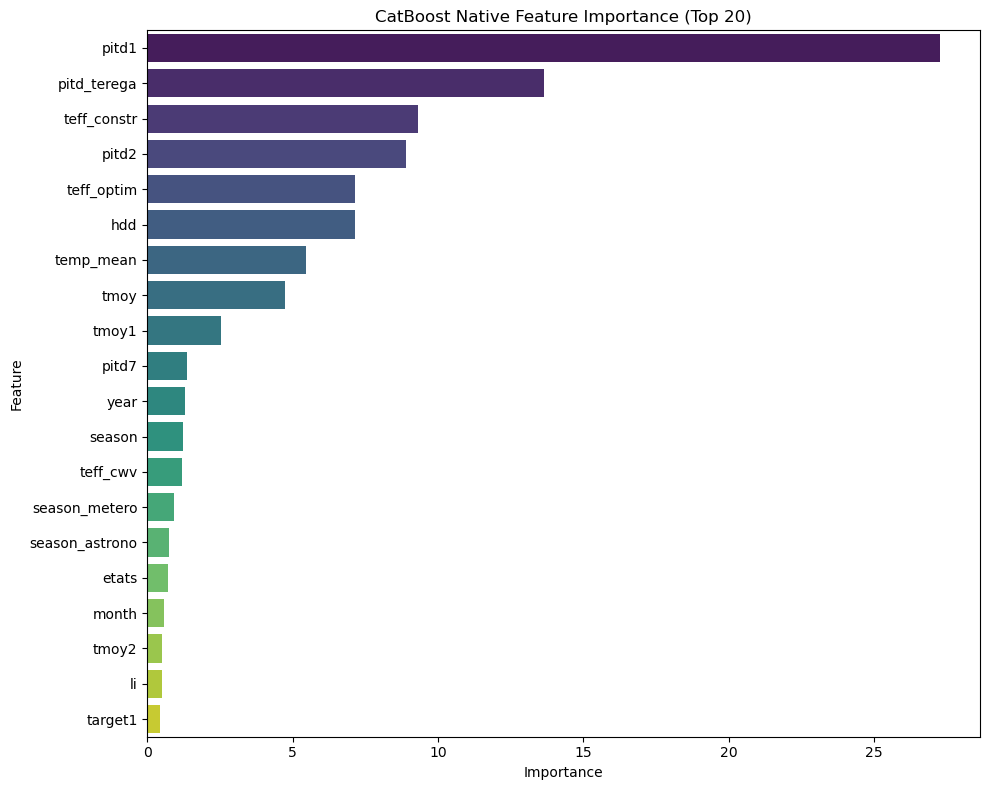


Generating SHAP plots...


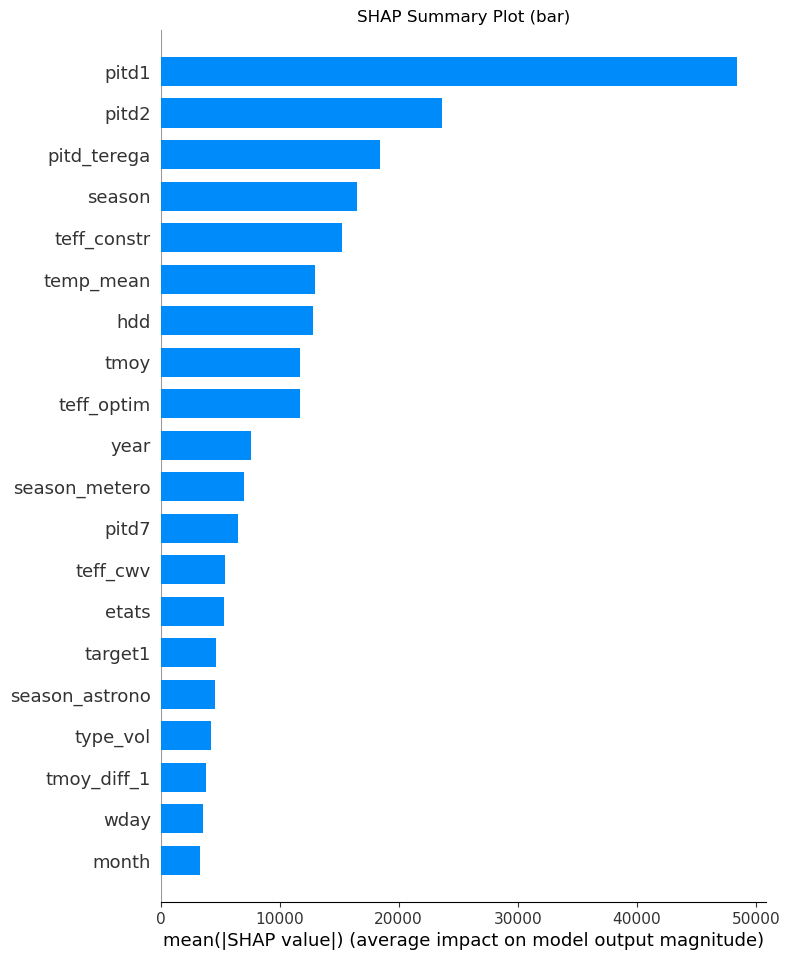

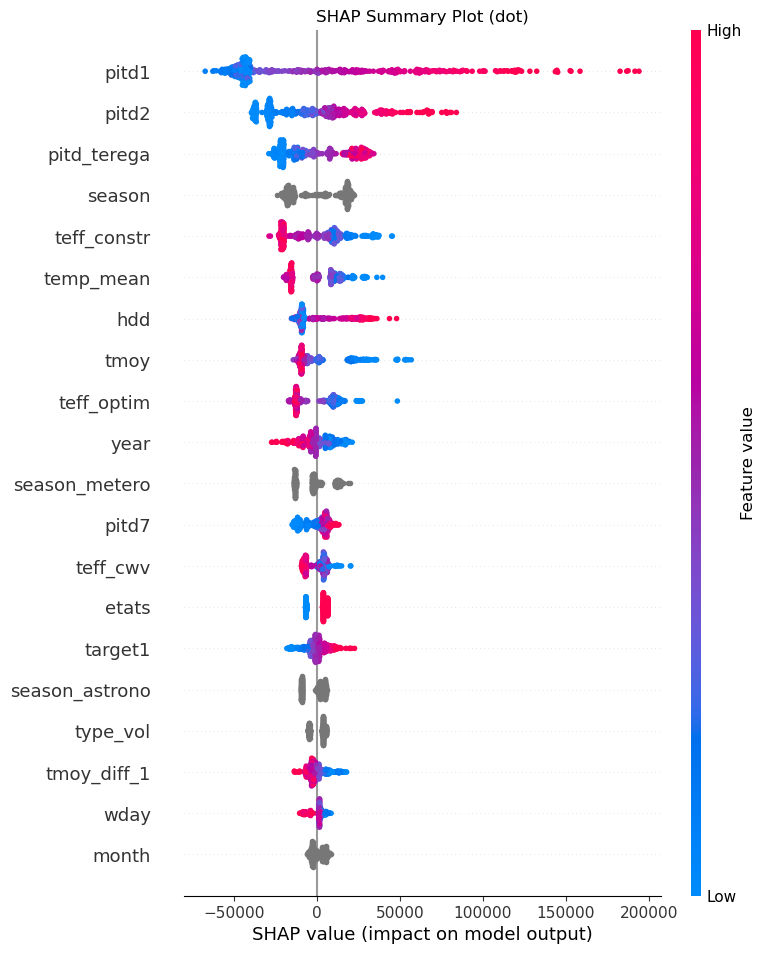

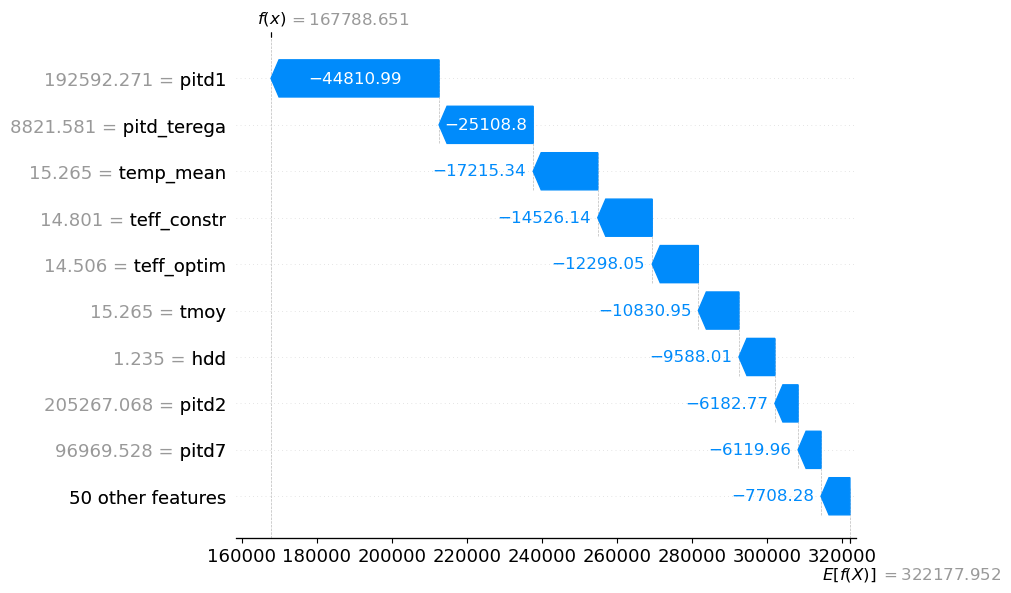


Script section finished.


In [38]:
# %% [markdown]
# # 4. Overall Model Comparison & Final Analysis

# %%
print("\n" + "="*50)
print("--- Overall Model Comparison & Analysis ---")

# --- Define paths and Load External Models ---
print("Loading previously trained external models...")
models_to_load_paths = {
    "Baseline": 'models/cb_base_model.cbm',
    "TimeAware": 'models/cb_time_model.cbm',
    "Golden": 'models/cb_golden_model.cbm',
}
loaded_models = {}
model_metrics_recalculated = {} # Store metrics calculated from loaded models

# Or ensure RMSE, MAPE, calculate_r2 are imported from utils if using those

for name, path in models_to_load_paths.items():
    try:
        model = CatBoostRegressor() # Initialize empty model
        model.load_model(path)
        loaded_models[name] = model
        print(f"Loaded model '{name}' from {path}")

        # --- Calculate metrics for the loaded model ---
        print(f"  Calculating metrics for loaded model '{name}'...")
        y_pred_loaded = model.predict(X_test) # Use the consistent test set
        # Using sklearn metrics directly:
        rmse_loaded = root_mean_squared_error(y_test, y_pred_loaded)
        mape_loaded = mean_absolute_percentage_error(y_test, y_pred_loaded) * 100
        r2_loaded = r2_score(y_test, y_pred_loaded)
        # Store metrics
        model_metrics_recalculated[name] = {'RMSE': rmse_loaded, 'MAPE': mape_loaded, 'R2': r2_loaded}
        print(f"  Metrics for '{name}': RMSE={rmse_loaded:.2f}, MAPE={mape_loaded:.2f}%, R2={r2_loaded:.4f}")

    except Exception as e:
        print(f"Error loading or evaluating model '{name}' from {path}: {e}. Skipping.")

# --- Combine All Models (Loaded + Internally Trained) ---
print("\nCombining all models for comparison...")
all_models_to_compare = {}
all_models_to_compare.update(loaded_models) # Add loaded models first

# Add models trained within this script (check if they exist and are fitted)
if 'final_model_rs' in locals() and final_model_rs is not None and final_model_rs.is_fitted():
    all_models_to_compare["RandomSearch"] = final_model_rs
    print("Added 'RandomSearch' model.")
if 'final_model_gs' in locals() and final_model_gs is not None and final_model_gs.is_fitted():
    all_models_to_compare["GridSearch_FineTuned"] = final_model_gs
    print("Added 'GridSearch_FineTuned' model.")
if 'final_model_optuna_focused' in locals() and final_model_optuna_focused is not None and final_model_optuna_focused.is_fitted():
    all_models_to_compare["Optuna_FineTuned"] = final_model_optuna_focused
    print("Added 'Optuna_FineTuned' model.")

# Filter for valid, fitted models
valid_models_to_compare_all = {k: v for k, v in all_models_to_compare.items() if v is not None and v.is_fitted()}
print(f"Found {len(valid_models_to_compare_all)} valid models for comparison: {list(valid_models_to_compare_all.keys())}")

# --- Create Metrics DataFrame (using calculated metrics) ---
print("\nCreating final metrics comparison table...")
all_metrics_data = {}
# Add metrics calculated within this script
if 'rs_model_metrics' in locals(): all_metrics_data['RandomSearch'] = rs_model_metrics
if 'gs_model_metrics' in locals(): all_metrics_data['GridSearch_FineTuned'] = gs_model_metrics
if 'optuna_focused_model_metrics' in locals(): all_metrics_data['Optuna_FineTuned'] = optuna_focused_model_metrics
# Add metrics recalculated from loaded models
all_metrics_data.update(model_metrics_recalculated)

if not all_metrics_data:
     print("Warning: No model metrics available for comparison table.")
     comparison_df_all = pd.DataFrame() # Empty DataFrame
else:
     comparison_df_all = pd.DataFrame(all_metrics_data).T
     # Ensure required columns exist before ordering
     cols_to_show = [col for col in ['RMSE', 'MAPE', 'R2'] if col in comparison_df_all.columns]
     if cols_to_show:
         comparison_df_all = comparison_df_all[cols_to_show]
         print("\nCombined Model Performance Comparison on Test Set:")
         print(comparison_df_all.to_string(float_format="%.4f"))
     else:
         print("Warning: No standard metric columns (RMSE, MAPE, R2) found in metrics data.")
         comparison_df_all = pd.DataFrame() # Reset if no valid columns



if len(valid_models_to_compare_all) < 2:
    print("Need at least two valid trained models to compare.")
else:
    # Create comparison pool (uses original test set)
    # Ensure Pool is imported: from catboost import Pool
    try:
        comparison_pool = Pool(data=X_test, label=y_test, cat_features=cat_variables)
        model_names_all = list(valid_models_to_compare_all.keys())
        # Loop through unique pairs
        for i in range(len(model_names_all)):
            for j in range(i + 1, len(model_names_all)):
                name1 = model_names_all[i]
                name2 = model_names_all[j]
                model_obj1 = valid_models_to_compare_all[name1]
                model_obj2 = valid_models_to_compare_all[name2]

                print(f"\nComparing '{name1}' vs '{name2}'...")
                try:
                    # --- MODIFIED: Use the model.compare() method syntax ---
                    # Note: Metrics are passed as a list, e.g., ['RMSE']
                    comp_df = model_obj1.compare(
                        model_obj2,
                        comparison_pool,
                        metrics=['RMSE'] # Use the 'metrics' argument as a list
                    )
                    # --- End Modification ---

                    # Display summary stats (assuming output DataFrame structure is similar)
                    print("Comparison Summary (RMSE):")
                    # Adjust column names here if the output DataFrame is different
                    print(comp_df[['metric_name', 'model1_wins', 'model2_wins', 'metric_value_diff']].head())

                except Exception as e:
                    print(f"  Could not compare {name1} and {name2}. Error: {e}")

    except NameError as ne:
         print(f"Error creating comparison pool or accessing models: {ne}")
         print("Ensure X_test, y_test, and cat_variables are defined.")
    except Exception as ex:
         print(f"An unexpected error occurred during comparison setup: {ex}")

print("="*50 + "\n")



# --- Final Model Analysis (Choose Overall Best based on Metrics Table) ---
print("\n--- Final Model Analysis (Overall Best) ---")
final_model_to_analyze = None
best_model_name = None

if not comparison_df_all.empty and 'RMSE' in comparison_df_all.columns:
     try:
         # Select model with lowest RMSE from the metrics table
         best_model_name = comparison_df_all['RMSE'].astype(float).idxmin() # Ensure RMSE is float for idxmin
         print(f"Selected '{best_model_name}' as best model based on lowest Test RMSE.")
         # Get the corresponding model object from the valid models dictionary
         final_model_to_analyze = valid_models_to_compare_all.get(best_model_name)
     except Exception as e:
          print(f"Could not determine best model from metrics table: {e}")

if final_model_to_analyze and final_model_to_analyze.is_fitted():
    print(f"\nAnalyzing model: {best_model_name}")
    print("\nPlotting native feature importance...")
    # Ensure X_train exists and has columns for feature names
    if 'X_train' in locals() and hasattr(X_train, 'columns'):
        final_feature_names = X_train.columns.tolist()
        plot_native_feature_importance(final_model_to_analyze, final_feature_names)
    else:
        print("Warning: Cannot get feature names for native importance plot (X_train not available?).")

    print("\nGenerating SHAP plots...")
    # Ensure X_test exists for SHAP plots
    if 'X_test' in locals():
        plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="bar")
        plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="dot")
        plot_shap_waterfall(final_model_to_analyze, X_test, final_feature_names, instance_index=1)
    else:
        print("Warning: Cannot generate SHAP plots (X_test not available?).")
else:
    print("No final best model available for analysis (either none found or selection failed).")

print("\n" + "="*50)
print("Script section finished.")


--- Overall Model Comparison & Analysis (with CV Evaluation) ---
Using 10-Fold Cross-Validation for model evaluation metrics.

Loading previously trained external models...
Loaded model 'Baseline' from models/cb_base_model.cbm
  Calculating CV metrics for loaded model 'Baseline'...


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

Error loading or evaluating model 'Baseline' from models/cb_base_model.cbm: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.12/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/catboos

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

Error loading or evaluating model 'TimeAware' from models/cb_time_model.cbm: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.12/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/catboo

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Error loading or evaluating model 'Golden' from models/cb_golden_model.cbm: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.12/site-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/catboos

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


50:	learn: 32035.1051651	total: 2.56s	remaining: 1m 19s
51:	learn: 31697.1863015	total: 2.56s	remaining: 1m 18s
45:	learn: 34939.6935971	total: 2.46s	remaining: 1m 24s
52:	learn: 31543.0275633	total: 2.6s	remaining: 1m 17s
56:	learn: 30062.9957119	total: 2.45s	remaining: 1m 7s
57:	learn: 29767.3791253	total: 2.46s	remaining: 1m 6s
53:	learn: 31076.3769418	total: 2.61s	remaining: 1m 16s
58:	learn: 29454.5589321	total: 2.46s	remaining: 1m 5s
59:	learn: 29190.1786606	total: 2.47s	remaining: 1m 4s
45:	learn: 35214.0018298	total: 2.68s	remaining: 1m 32s
60:	learn: 28849.5070235	total: 2.47s	remaining: 1m 3s
52:	learn: 31320.2820422	total: 2.62s	remaining: 1m 18s
61:	learn: 28547.2733452	total: 2.49s	remaining: 1m 3s
54:	learn: 30663.1518140	total: 2.65s	remaining: 1m 16s
53:	learn: 30882.4719396	total: 2.64s	remaining: 1m 17s
46:	learn: 34459.3610118	total: 2.72s	remaining: 1m 31s
62:	learn: 28289.6364524	total: 2.51s	remaining: 1m 2s
55:	learn: 30259.0961596	total: 2.66s	remaining: 1m 14s


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


54:	learn: 30115.3892625	total: 2.8s	remaining: 1m 20s
58:	learn: 28966.8193215	total: 3s	remaining: 1m 20s
78:	learn: 24952.4728623	total: 2.8s	remaining: 55.3s
59:	learn: 28721.7191061	total: 3.02s	remaining: 1m 19s
79:	learn: 24836.2652131	total: 2.85s	remaining: 55.4s
60:	learn: 28430.2291455	total: 3.05s	remaining: 1m 18s
65:	learn: 27552.0230960	total: 3.01s	remaining: 1m 11s
61:	learn: 28088.4227868	total: 3.06s	remaining: 1m 17s
80:	learn: 24736.9334375	total: 2.87s	remaining: 55.1s
62:	learn: 27784.6753138	total: 3.07s	remaining: 1m 16s
82:	learn: 24107.1985619	total: 2.98s	remaining: 55.8s
81:	learn: 24573.7777830	total: 2.88s	remaining: 54.5s
83:	learn: 24022.0598545	total: 2.99s	remaining: 55.2s
82:	learn: 24470.9029705	total: 2.89s	remaining: 54.1s
63:	learn: 27568.2308374	total: 3.1s	remaining: 1m 16s
84:	learn: 23926.2258071	total: 3.01s	remaining: 55s
85:	learn: 23775.8035414	total: 3.02s	remaining: 54.3s
83:	learn: 24352.2755727	total: 2.93s	remaining: 54.2s
64:	learn:

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


117:	learn: 21254.4067497	total: 3.77s	remaining: 48.5s
118:	learn: 21183.8677250	total: 3.78s	remaining: 48.2s
119:	learn: 21130.2600082	total: 3.82s	remaining: 48.3s
120:	learn: 21074.4887645	total: 3.85s	remaining: 48.2s
75:	learn: 25829.2147557	total: 3.91s	remaining: 1m 20s
121:	learn: 21014.2236155	total: 3.86s	remaining: 47.9s
122:	learn: 20966.2516842	total: 3.86s	remaining: 47.5s
84:	learn: 24189.5227913	total: 3.83s	remaining: 1m 9s
85:	learn: 24053.3963599	total: 3.85s	remaining: 1m 9s
86:	learn: 23921.8281681	total: 3.85s	remaining: 1m 8s
87:	learn: 23820.9884715	total: 3.86s	remaining: 1m 7s
88:	learn: 23688.4435980	total: 3.86s	remaining: 1m 7s
89:	learn: 23559.8838024	total: 3.87s	remaining: 1m 6s
90:	learn: 23459.1580555	total: 3.87s	remaining: 1m 5s
72:	learn: 25787.0483719	total: 4.07s	remaining: 1m 27s


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

123:	learn: 20892.0109699	total: 3.97s	remaining: 48.5s
124:	learn: 20854.7178685	total: 3.98s	remaining: 48.1s
91:	learn: 23372.4155474	total: 3.88s	remaining: 1m 5s
76:	learn: 25656.5643441	total: 4.04s	remaining: 1m 21s
73:	learn: 25634.3767832	total: 4.09s	remaining: 1m 26s
56:	learn: 29465.9494767	total: 3.9s	remaining: 1m 48s
74:	learn: 25470.8852734	total: 4.09s	remaining: 1m 25s
92:	learn: 23288.2237426	total: 3.9s	remaining: 1m 4s
77:	learn: 25467.3160511	total: 4.05s	remaining: 1m 20s
125:	learn: 20791.8730670	total: 4.02s	remaining: 48.2s
57:	learn: 29089.4872119	total: 3.94s	remaining: 1m 47s
126:	learn: 20723.5080745	total: 4.03s	remaining: 47.9s
78:	learn: 25349.9342826	total: 4.09s	remaining: 1m 20s
58:	learn: 28782.2540707	total: 3.95s	remaining: 1m 45s
75:	learn: 25284.6485050	total: 4.14s	remaining: 1m 25s
59:	learn: 28488.6939534	total: 3.95s	remaining: 1m 43s
127:	learn: 20677.7918953	total: 4.05s	remaining: 47.7s
76:	learn: 25132.8150309	total: 4.15s	remaining: 1m 

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


53:	learn: 39237.9128048	total: 2.36s	remaining: 1m 1s
35:	learn: 60790.1708590	total: 2.44s	remaining: 1m 37s
54:	learn: 38452.4207907	total: 2.36s	remaining: 1m
36:	learn: 59153.8031146	total: 2.46s	remaining: 1m 35s
37:	learn: 57437.4357661	total: 2.47s	remaining: 1m 33s
38:	learn: 55913.4885892	total: 2.48s	remaining: 1m 31s
39:	learn: 54491.4862652	total: 2.49s	remaining: 1m 29s
29:	learn: 72752.9369224	total: 2.17s	remaining: 1m 44s
40:	learn: 53056.3023682	total: 2.51s	remaining: 1m 27s
30:	learn: 70463.4067513	total: 2.19s	remaining: 1m 41s
25:	learn: 82820.1162135	total: 2.07s	remaining: 1m 55s
31:	learn: 68152.4499354	total: 2.24s	remaining: 1m 40s
41:	learn: 51664.1732422	total: 2.57s	remaining: 1m 27s
26:	learn: 80026.1520985	total: 2.21s	remaining: 1m 58s
32:	learn: 66017.9251396	total: 2.35s	remaining: 1m 42s
33:	learn: 64192.4376425	total: 2.35s	remaining: 1m 39s
51:	learn: 41535.5166732	total: 2.3s	remaining: 1m 2s
34:	learn: 62299.6067349	total: 2.36s	remaining: 1m 36s

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


40:	learn: 52847.6852940	total: 2.55s	remaining: 1m 29s
0:	learn: 220099.6813255	total: 269ms	remaining: 6m 36s
45:	learn: 47021.3950910	total: 2.83s	remaining: 1m 27s
31:	learn: 67584.6093133	total: 2.45s	remaining: 1m 50s
41:	learn: 51440.6458270	total: 2.57s	remaining: 1m 27s
42:	learn: 50226.3686705	total: 2.59s	remaining: 1m 26s
1:	learn: 211588.7014956	total: 308ms	remaining: 3m 46s
43:	learn: 49004.0050822	total: 2.62s	remaining: 1m 25s
2:	learn: 203208.8319000	total: 353ms	remaining: 2m 53s
44:	learn: 47846.4977937	total: 2.65s	remaining: 1m 24s
45:	learn: 46827.1211472	total: 2.66s	remaining: 1m 22s
46:	learn: 45711.9126959	total: 2.73s	remaining: 1m 22s
46:	learn: 45981.1431613	total: 2.91s	remaining: 1m 28s
32:	learn: 65478.9918881	total: 2.63s	remaining: 1m 54s
0:	learn: 221141.7476978	total: 334ms	remaining: 8m 12s
57:	learn: 36697.4774911	total: 3.03s	remaining: 1m 13s
47:	learn: 45010.2983707	total: 2.98s	remaining: 1m 28s
58:	learn: 36217.1350280	total: 3.07s	remaining:

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

61:	learn: 35497.7584895	total: 2.89s	remaining: 1m 5s
67:	learn: 32163.2426354	total: 3.21s	remaining: 1m 6s
68:	learn: 31774.0809566	total: 3.22s	remaining: 1m 5s
69:	learn: 31407.1276461	total: 3.22s	remaining: 1m 4s
62:	learn: 35018.4517921	total: 2.9s	remaining: 1m 4s
63:	learn: 34472.1003145	total: 2.9s	remaining: 1m 3s
64:	learn: 34008.3630454	total: 2.91s	remaining: 1m 3s
7:	learn: 165284.0256400	total: 750ms	remaining: 2m 17s
65:	learn: 33715.2519051	total: 2.95s	remaining: 1m 2s
51:	learn: 41526.2240689	total: 3.25s	remaining: 1m 28s
37:	learn: 56521.9481116	total: 2.95s	remaining: 1m 51s
66:	learn: 33253.8885429	total: 2.97s	remaining: 1m 2s
47:	learn: 44754.8096372	total: 3.09s	remaining: 1m 31s
67:	learn: 32790.6384119	total: 2.98s	remaining: 1m 1s
68:	learn: 32404.1160015	total: 3.03s	remaining: 1m 1s
8:	learn: 158722.2262188	total: 880ms	remaining: 2m 23s
48:	learn: 43868.4459705	total: 3.17s	remaining: 1m 32s
49:	learn: 42980.2145126	total: 3.18s	remaining: 1m 30s
50:	l

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


8:	learn: 158847.0080208	total: 1s	remaining: 2m 43s
9:	learn: 152552.8390057	total: 1.02s	remaining: 2m 29s
10:	learn: 146484.9302026	total: 1.02s	remaining: 2m 16s
70:	learn: 31009.7400660	total: 3.71s	remaining: 1m 13s
11:	learn: 140961.4522068	total: 1.06s	remaining: 2m 8s
71:	learn: 30689.1245723	total: 3.73s	remaining: 1m 12s
72:	learn: 30390.0414572	total: 3.76s	remaining: 1m 12s
73:	learn: 30036.6329508	total: 3.8s	remaining: 1m 11s
0:	learn: 221441.3119909	total: 192ms	remaining: 4m 42s
74:	learn: 29781.2083456	total: 3.8s	remaining: 1m 10s
75:	learn: 29539.7975816	total: 3.81s	remaining: 1m 10s
76:	learn: 29228.7240032	total: 3.82s	remaining: 1m 9s
38:	learn: 54889.9413348	total: 3.47s	remaining: 2m 7s
1:	learn: 212126.0002180	total: 223ms	remaining: 2m 44s
77:	learn: 28996.3005910	total: 3.83s	remaining: 1m 8s
12:	learn: 135329.1976147	total: 1.22s	remaining: 2m 16s
2:	learn: 203630.4096559	total: 247ms	remaining: 2m
3:	learn: 195102.4334074	total: 258ms	remaining: 1m 34s
77

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Baseline and TimeAware. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Golden' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Baseline and Golden. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'RandomSearch' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Baseline and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'GridSearch_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Baseline and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Optuna_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Baseline and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Golden' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare TimeAware and Golden. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'RandomSearch' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare TimeAware and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'GridSearch_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare TimeAware and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Optuna_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare TimeAware and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'RandomSearch' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Golden and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'GridSearch_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Golden and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'Optuna_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare Golden and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'RandomSearch' vs 'GridSearch_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare RandomSearch and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'RandomSearch' vs 'Optuna_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare RandomSearch and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'GridSearch_FineTuned' vs 'Optuna_FineTuned' on Test Set...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE on Test Set):
  Could not compare GridSearch_FineTuned and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable


--- Final Model Analysis (Overall Best based on CV Metrics) ---
Selected 'GridSearch_FineTuned' as best model based on lowest Mean CV RMSE.

Analyzing model: GridSearch_FineTuned

Plotting native feature importance...
Native importance plot generation skipped for Azure ML script.

Generating SHAP plots...


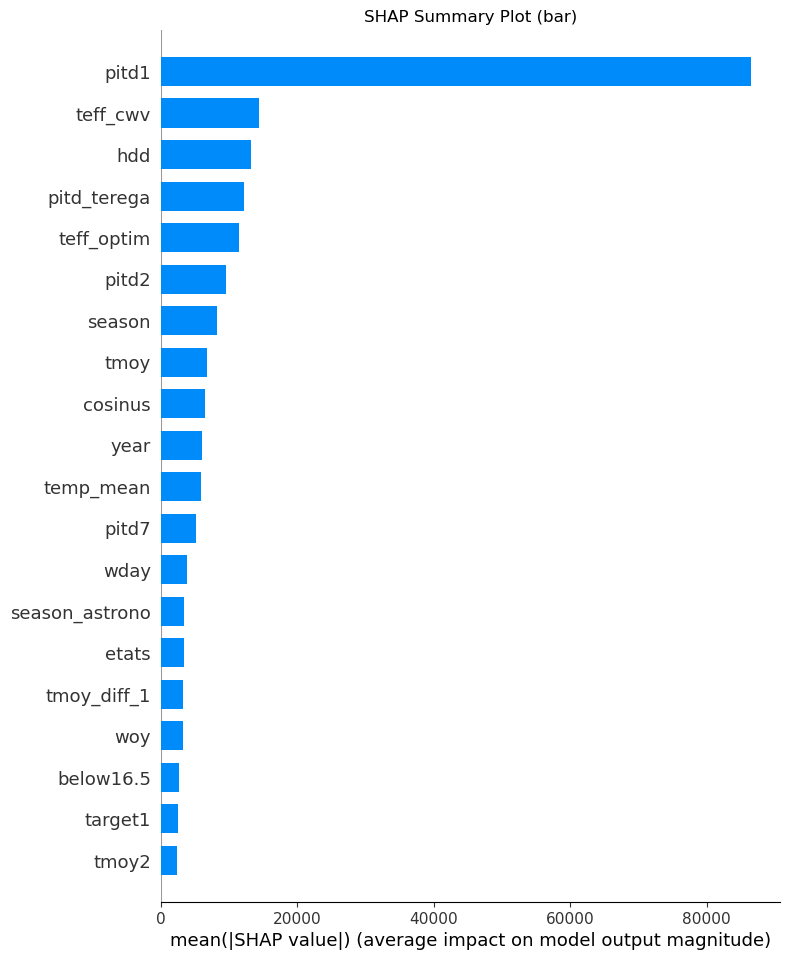

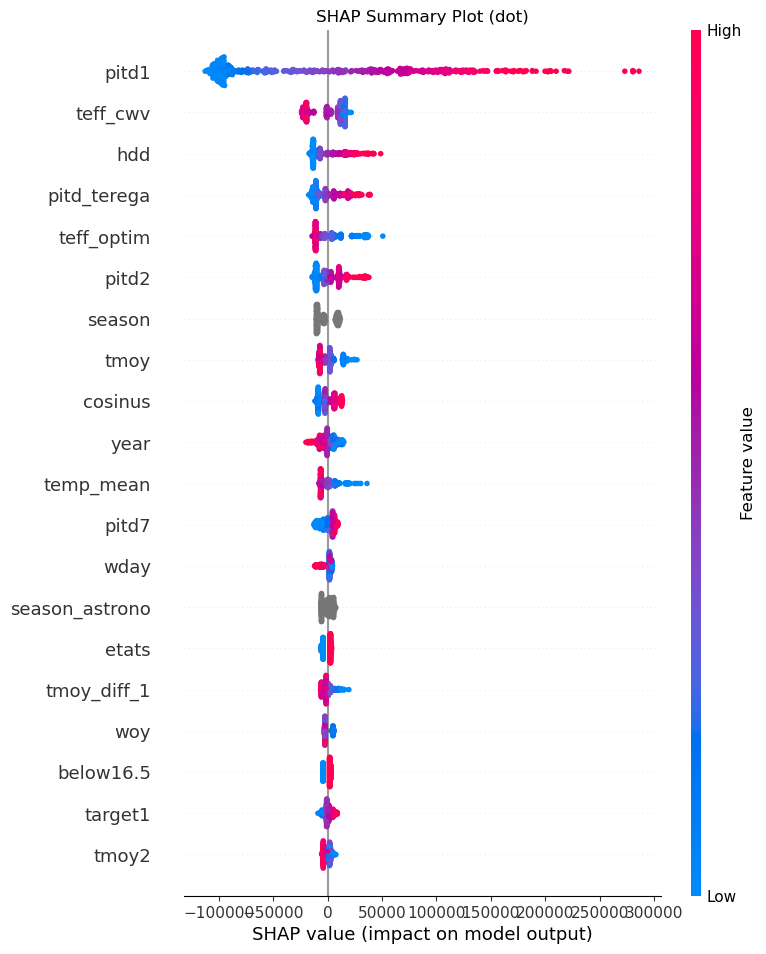

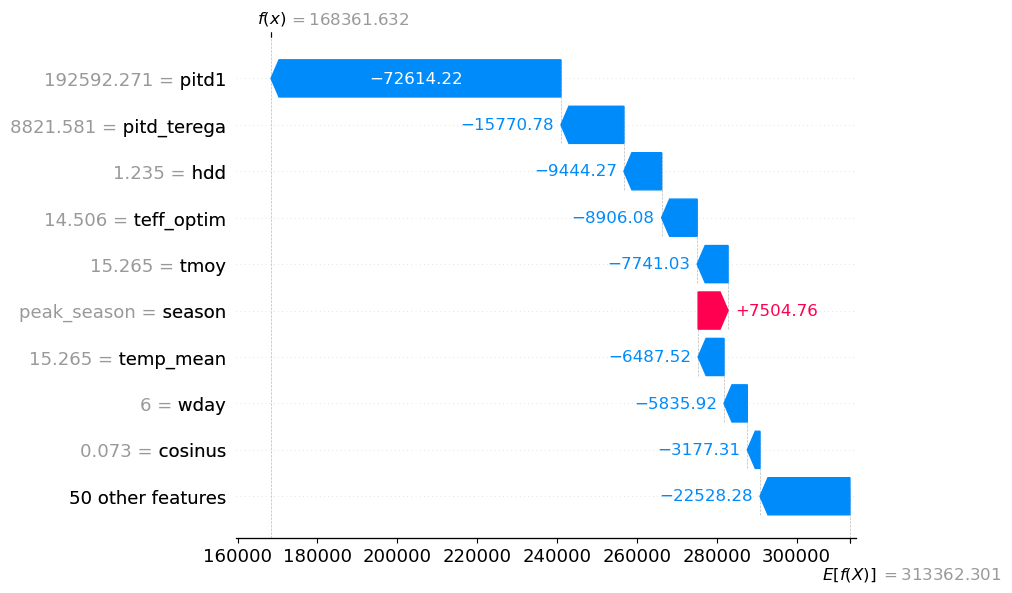

SHAP plot generation skipped for Azure ML script.

Script section finished.


In [39]:
print("\n" + "="*50)
print("--- Overall Model Comparison & Analysis (with CV Evaluation) ---")

# Imports for CV and metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor, Pool # Ensure Pool is imported
import numpy as np
import pandas as pd
import os # Ensure os is imported

# --- Define CV Strategy and Scoring for Evaluation ---
N_CV_EVAL_FOLDS = 10 # Number of folds for evaluation CV
cv_eval = KFold(n_splits=N_CV_EVAL_FOLDS, shuffle=True, random_state=RANDOM_STATE)
# Define scorers for cross_validate (note: error metrics are negated)
scoring_dict = {
    'neg_rmse': make_scorer(root_mean_squared_error, greater_is_better=False),
    'neg_mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}
print(f"Using {N_CV_EVAL_FOLDS}-Fold Cross-Validation for model evaluation metrics.")

# --- Define paths and Load External Models ---
print("\nLoading previously trained external models...")
models_to_load_paths = {
    "Baseline": 'models/cb_base_model.cbm',
    "TimeAware": 'models/cb_time_model.cbm',
    "Golden": 'models/cb_golden_model.cbm',
}
loaded_models = {}
# Store the MEAN CV metrics for each model
model_cv_metrics = {}

for name, path in models_to_load_paths.items():
    try:
        model = CatBoostRegressor() # Initialize empty model
        model.load_model(path)
        loaded_models[name] = model
        print(f"Loaded model '{name}' from {path}")

        # --- Calculate Cross-Validated metrics for the loaded model ---
        print(f"  Calculating CV metrics for loaded model '{name}'...")
        # Use X_train, y_train for CV evaluation
        cv_results = cross_validate(
            model, X_train, y_train, cv=cv_eval, scoring=scoring_dict, n_jobs=-1
        )

        # Calculate mean scores and handle negation for error metrics
        mean_rmse = -np.mean(cv_results['test_neg_rmse']) # Negate back to positive RMSE
        mean_mape = -np.mean(cv_results['test_neg_mape']) * 100 # Negate back and convert to %
        mean_r2 = np.mean(cv_results['test_r2'])

        # Store mean CV metrics
        model_cv_metrics[name] = {'RMSE': mean_rmse, 'MAPE': mean_mape, 'R2': mean_r2}
        print(f"  Mean CV Metrics for '{name}': RMSE={mean_rmse:.2f}, MAPE={mean_mape:.2f}%, R2={mean_r2:.4f}")

    except FileNotFoundError:
         print(f"Error loading model '{name}': File not found at {path}. Skipping.")
    except Exception as e:
        print(f"Error loading or evaluating model '{name}' from {path}: {e}. Skipping.")

# --- Calculate CV Metrics for Internally Trained Models ---
print("\nCalculating CV metrics for internally trained models...")
internal_models_to_eval = {}
if 'final_model_rs' in locals() and final_model_rs is not None and final_model_rs.is_fitted():
    internal_models_to_eval["RandomSearch"] = final_model_rs
if 'final_model_gs' in locals() and final_model_gs is not None and final_model_gs.is_fitted():
    internal_models_to_eval["GridSearch_FineTuned"] = final_model_gs
if 'final_model_optuna_focused' in locals() and final_model_optuna_focused is not None and final_model_optuna_focused.is_fitted():
    internal_models_to_eval["Optuna_FineTuned"] = final_model_optuna_focused

for name, model in internal_models_to_eval.items():
    try:
        print(f"  Calculating CV metrics for internally trained model '{name}'...")
        cv_results = cross_validate(
            model, X_train, y_train, cv=cv_eval, scoring=scoring_dict, n_jobs=-1
        )
        mean_rmse = -np.mean(cv_results['test_neg_rmse'])
        mean_mape = -np.mean(cv_results['test_neg_mape']) * 100
        mean_r2 = np.mean(cv_results['test_r2'])
        model_cv_metrics[name] = {'RMSE': mean_rmse, 'MAPE': mean_mape, 'R2': mean_r2}
        print(f"  Mean CV Metrics for '{name}': RMSE={mean_rmse:.2f}, MAPE={mean_mape:.2f}%, R2={mean_r2:.4f}")
    except Exception as e:
        print(f"Error calculating CV metrics for internal model '{name}': {e}. Skipping.")


# --- Combine All Models (Loaded + Internally Trained) for .compare ---
print("\nCombining all models for comparison...")
all_models_to_compare = {}
all_models_to_compare.update(loaded_models) # Add loaded models
all_models_to_compare.update(internal_models_to_eval) # Add internal models

# Filter for valid, fitted models
valid_models_to_compare_all = {k: v for k, v in all_models_to_compare.items() if v is not None and hasattr(v, 'is_fitted') and v.is_fitted()}
print(f"Found {len(valid_models_to_compare_all)} valid models for comparison: {list(valid_models_to_compare_all.keys())}")


# --- Create Metrics DataFrame (using MEAN CV metrics) ---
print("\nCreating final metrics comparison table using Mean CV Scores...")
if not model_cv_metrics:
     print("Warning: No model CV metrics available for comparison table.")
     comparison_df_all = pd.DataFrame() # Empty DataFrame
else:
     comparison_df_all = pd.DataFrame(model_cv_metrics).T
     # Ensure required columns exist before ordering
     cols_to_show = [col for col in ['RMSE', 'MAPE', 'R2'] if col in comparison_df_all.columns]
     if cols_to_show:
         comparison_df_all = comparison_df_all[cols_to_show]
         print("\nCombined Model Performance Comparison (Mean CV Scores on Training Data):")
         print(comparison_df_all.sort_values('RMSE').to_string(float_format="%.4f")) # Sort by RMSE
         # --- Save CV metrics comparison to JSON ---
         if 'METRICS_FILENAME' in locals() and METRICS_FILENAME:
             print(f"Saving final CV metrics comparison to {METRICS_FILENAME}...")
             try:
                 comparison_df_all.to_json(METRICS_FILENAME, indent=4, orient="index")
             except Exception as e:
                 print(f"  Error saving metrics file: {e}")
         # --- Log CV metrics table as artifact ---
         if 'mlflow' in locals():
             try:
                 mlflow.log_dict(comparison_df_all.to_dict(orient="index"), "final_cv_metrics_comparison.json")
                 print("Logged CV metrics comparison to MLflow artifacts.")
             except Exception as e:
                 print(f"  Error logging metrics table artifact: {e}")
     else:
         print("Warning: No standard metric columns (RMSE, MAPE, R2) found in CV metrics data.")
         comparison_df_all = pd.DataFrame() # Reset if no valid columns


# --- Run CatBoost `.compare()` on the TEST SET ---
# Note: .compare() still uses the single test split for direct comparison
print("\n--- Comparing CatBoost Models using model.compare() on Test Set ---")
if len(valid_models_to_compare_all) < 2:
    print("Need at least two valid trained models to run model.compare().")
else:
    # Create comparison pool using the original TEST set
    try:
        # Use X_test which was saved after the initial split
        comparison_pool = Pool(data=X_test, label=y_test, cat_features=cat_variables)
        model_names_all = list(valid_models_to_compare_all.keys())
        # Loop through unique pairs
        for i in range(len(model_names_all)):
            for j in range(i + 1, len(model_names_all)):
                name1 = model_names_all[i]
                name2 = model_names_all[j]
                model_obj1 = valid_models_to_compare_all.get(name1) # Use .get for safety
                model_obj2 = valid_models_to_compare_all.get(name2)

                # --- Explicit Check for None before comparing ---
                if model_obj1 is None or not model_obj1.is_fitted():
                    print(f"Skipping comparison involving '{name1}': Model object is None or not fitted.")
                    continue
                if model_obj2 is None or not model_obj2.is_fitted():
                    print(f"Skipping comparison involving '{name2}': Model object is None or not fitted.")
                    continue
                # --- End Explicit Check ---

                print(f"\nComparing '{name1}' vs '{name2}' on Test Set...")
                try:
                    comp_df = model_obj1.compare(
                        model_obj2,
                        comparison_pool,
                        metrics=['RMSE'] # Compare based on RMSE on the test set pool
                    )
                    print("Comparison Summary (RMSE on Test Set):")
                    print(comp_df[['metric_name', 'model1_wins', 'model2_wins', 'metric_value_diff']].head())
                except Exception as e:
                    print(f"  Could not compare {name1} and {name2}. Error: {e}")

    except NameError as ne:
         print(f"Error creating comparison pool or accessing models: {ne}")
         print("Ensure X_test, y_test, and cat_variables are defined.")
    except Exception as ex:
         print(f"An unexpected error occurred during comparison setup: {ex}")

print("="*50 + "\n")


# --- Final Model Analysis (Choose Overall Best based on CV Metrics Table) ---
print("\n--- Final Model Analysis (Overall Best based on CV Metrics) ---")
final_model_to_analyze = None
best_model_name = None

# Use the comparison_df_all which now contains CV metrics
if not comparison_df_all.empty and 'RMSE' in comparison_df_all.columns:
     try:
         # Select model with lowest MEAN CV RMSE from the metrics table
         best_model_name = comparison_df_all['RMSE'].astype(float).idxmin()
         print(f"Selected '{best_model_name}' as best model based on lowest Mean CV RMSE.")
         # Get the corresponding model object from the valid models dictionary
         final_model_to_analyze = valid_models_to_compare_all.get(best_model_name)
     except Exception as e:
          print(f"Could not determine best model from CV metrics table: {e}")

# Analyze the selected best model (trained on full training data)
if final_model_to_analyze and final_model_to_analyze.is_fitted():
    print(f"\nAnalyzing model: {best_model_name}")
    # Feature Importance (using the model trained on full X_train)
    print("\nPlotting native feature importance...")
    if 'X_train' in locals() and hasattr(X_train, 'columns'):
        final_feature_names = X_train.columns.tolist()
        # Assuming plot_native_feature_importance is available from utils
        # You might want to disable plotting in Azure ML jobs or save plots to output dir
        try:
             from utils import plot_native_feature_importance
             # plot_native_feature_importance(final_model_to_analyze, final_feature_names) # Comment out plt.show() in utils for Azure ML
             print("Native importance plot generation skipped for Azure ML script.")
        except ImportError:
             print("Could not import plot_native_feature_importance from utils.")
    else:
        print("Warning: Cannot get feature names for native importance plot.")

    # SHAP Analysis (Optional - can be computationally expensive)
    print("\nGenerating SHAP plots...")
    if 'X_test' in locals() and 'final_feature_names' in locals():
        try:
            from utils import plot_shap_summary, plot_shap_waterfall
            plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="bar") # Comment out plt.show()
            plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="dot") # Comment out plt.show()
            plot_shap_waterfall(final_model_to_analyze, X_test, final_feature_names, instance_index=1) # Comment out plt.show()
            print("SHAP plot generation skipped for Azure ML script.")
        except ImportError:
             print("Could not import SHAP plotting functions from utils.")
    else:
        print("Warning: Cannot generate SHAP plots (X_test or feature names not available?).")
else:
    print("No final best model available for analysis (either none found or selection failed).")

print("\n" + "="*50)
print("Script section finished.")
# %%
